#**`Network Construction`**

First, we mount the drive, set the directory, and import the dataset.

In [ ]:
import os 
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")

In [ ]:
df = pd.read_csv("20230312_Nordstream_df.csv")
df

Secondly, we import the igraph library and construct the network

In [ ]:
! pip install igraph

In [ ]:
import igraph

network = igraph.Graph.TupleList([(row['author_id'], 
                                   row['sourcetweet_author_id']) for index, row in df.iterrows() if row['retweet_count'] > 0 and not pd.isna(row['sourcetweet_author_id'])], directed=True)

igraph.summary(network)
igraph.write(network.simplify(), "nordstream.gml", format="gml")

Third, we import the gml file to Gephi to calculate the network statistics (Modularity and Page Rank) and visualisation (Force Atlas 2).

# **`Topic Modelling`**

First, we import the dataset with the statistics from Gephi and create subsets for the top communities.

In [ ]:
df = pd.read_csv("NordstreamSabotage_class_data.csv")
df

In [ ]:
df["community_id"].groupby(df['community_id']).value_counts().nlargest(10) # visualise top 10 communities 

In [ ]:
# create subsets for top 5 communities
df180 = df[df["community_id"] == 180]
df106 = df[df["community_id"] == 106]
df246 = df[df["community_id"] == 246]
df1029= df[df["community_id"] == 1029]
df271 = df[df["community_id"] == 271]


In [ ]:
# and for the next 3 communities
df479 = df[df["community_id"] == 479]
df771 = df[df["community_id"] == 771]
df232 = df[df["community_id"] == 232]  

## **BERTopic**

###Install BERTopic, load libraries, text setup

In [ ]:
!pip install bertopic

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english') + stopwords.words("german")

In [ ]:
#clean up the text data in the DataFrames by removing URLs, Twitter handles, and non-alphabetic characters, 
#and filter out empty tweets.
import re

df1029.text = df1029.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df1029.text = df1029.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df1029.text = df1029.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df1029 = df1029.loc[(df1029.text != ""), :]

df106.text = df106.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df106.text = df106.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df106.text = df106.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df106 = df106.loc[(df106.text != ""), :]

df180.text = df180.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df180.text = df180.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df180.text = df180.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df180 = df180.loc[(df180.text != ""), :]

df246.text = df246.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df246.text = df246.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df246.text = df246.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df246 = df246.loc[(df246.text != ""), :]

df271.text = df271.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df271.text = df271.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df271.text = df271.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df271 = df271.loc[(df271.text != ""), :]

df479.text = df479.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df479.text = df479.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df479.text = df479.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df479 = df479.loc[(df479.text != ""), :]

df771.text = df771.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df771.text = df771.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df771.text = df771.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df771 = df771.loc[(df771.text != ""), :]

df232.text = df232.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df232.text = df232.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df232.text = df232.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df232 = df232.loc[(df271.text != ""), :]

###Compute and save models on drive – Nordstream Dataset

####Top 5 communities

#####Com 1029

In [ ]:
documents = list(df1029['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=800, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language="multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
topic_model.save("Nordstream_com_1029_model")

In [ ]:
print("Total Number of Topics:", len(topic_model.get_topic_freq()))

Total Number of Topics: 8


#####Com 106

In [ ]:
documents = list(df106['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=800, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language = "multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
topic_model.save("Nordstream_com_106_model")	

In [ ]:
print("Total Number of Topics:", len(topic_model.get_topic_freq()))

##### Com 180

In [ ]:
documents = list(df180['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=800, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language = "multilingual"
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
topic_model.save("Nordstream_com_180_model")		

In [ ]:
print("Total Number of Topics:", len(topic_model.get_topic_freq()))

#####Com 246

In [ ]:
documents = list(df246['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors246 = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=800, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language = "multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors246)

In [ ]:
topic_model.save("Nordstream_com_246_model")	

In [ ]:
print("Total Number of Topics:", len(topic_model.get_topic_freq()))

#####Com 271

In [ ]:
documents = list(df271['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors271 = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=800, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language = "multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors271)

In [ ]:
topic_model.save("Nordstream_com_271_model")	

In [ ]:
print("Total Number of Topics:", len(topic_model.get_topic_freq()))

####Secondary 3 communities

Given that these communities are much smaller, we decided to reduce the min_cluster_size from 800 to 500 in order to have a similar amout of topics. This choice was made after trial and error, trying out different parameters' setups to see which worked best for our case.

#####Com 771

In [ ]:
documents = list(df771['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=300, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language="multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
topic_model.save("Nordstream_com_771_model_clussiz")	

#####Com 479

In [ ]:
documents = list(df479['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=500, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language = "multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
topic_model.save("Nordstream_com_479_model")	

#####Com 232

In [ ]:
documents = list(df232['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=300, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language = "multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
topic_model.save("Nordstream_com_232_model")	

###Load existing Models for analysis

In [ ]:
#TOP 5 COMMUNITIES
model106 = BERTopic.load("Nordstream_com_106_model")	
model246 = BERTopic.load("Nordstream_com_246_model")
model271 = BERTopic.load("Nordstream_com_271_model")
model1029 = BERTopic.load("Nordstream_com_1029_model")
model180 = BERTopic.load("Nordstream_com_246_model")

In [ ]:
#SECONDARY 3 COMMUNITIES
model232 = BERTopic.load("Nordstream_com_232_model")	
model479 = BERTopic.load("Nordstream_com_479_model")	
model771 = BERTopic.load("Nordstream_com_771_model")	


###Interpret and analyse the BERTopic models

In [ ]:
#Assign topics back to their original tweets
df1029["topics"] = model1029.topics_
df106["topics"] = model106.topics_
df180["topics"] = model1029.topics_
df246["topics"] = model246.topics_
df271["topics"] = model271.topics_
df232["topics"] = model271.topics_
df771["topics"] = model271.topics_
df479["topics"] = model271.topics_

To analyse the topics we used the same functions for all communities. We decided to leave the functions here below only for community 106 but not to report the for all communities. This decision is because of the fact that the investigation was quite dynamic in looking into each topics by altering the code in the same cells rather than copying paste the code indefinitely.

In [ ]:
len(model106.get_topic_freq()) # number of topics

In [ ]:
model106.visualize_topics() # intertopic distance map

In [ ]:
model106.visualize_barchart(n_words=10, top_n_topics = 15) # terms bar chart

In [ ]:
freq = model106.get_topic_info(); freq.head(20) # terms visualisation

In [ ]:
model106.get_representative_docs() # representative tweets for the topics

In [ ]:
list(df106.text[df106["topics"] == x].sample(10)) # where "x" is the topic number to be visualised
# this was used to access samples of tweets in the dataset related to topic x in community n

In [ ]:
df106[df106.user_username == "username of interest"] 
# this was used to investigate tweets from different users who were quite prevalent in some topics 

In [ ]:
df106.loc[df106['text'].str.contains("insert string of interest")]
# this was used to identify lines containing certain words or sequences of words of interest

## **LDA Topic Modelling**

For the TOP 5 communities we also decided to run LDA topic modelling to compare the results.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# this forst two lines were needed to fix an error we got in installing textacy

! pip install textacy

In [ ]:
import textacy
import textacy.tm
from functools import partial

####Com 1029

#####Train

In [ ]:
documents = list(df1029['text'].str.lower())

In [ ]:
corpus = textacy.Corpus("en_core_web_sm", documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)

tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [ ]:
model = textacy.tm.TopicModel("lda", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

In [ ]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: stream   seymour   america   russia   pipeline   bombing   nord stream pipeline   htt   way   #germany
topic 1: biden   pipeline   world   nordstream   act   energy   war   destruction   response   crisis
topic 2: europeanunion   president   minded   damage   bad   clear   guy   child   nordst   good
topic 3: ufo   alaska   footage   ufoalaska   ufocanada   amazing   ufomontana   @drunk_opinion   #ufocanada #ufomontana   notuf
topic 4: #germany   nordstream   american   washington   zelensky   russia   interview   politician   scholz   china
topic 5: german   government   o   finding   source   journalist &   terrorist   journalist   attack   true
topic 6: gas   time   greenhouse   nordstream   leak   ton   us &amp   aftermath   delivery   halt
topic 7: hersh   group   ukrainian   country   air   reaction   nordstream   headline   new york times'   nordstr
topic 8: usa   diver   real   thread   cover   navy   summer   mid   ufotwitter   exe
topic 9: terrorism   act   attack   

#####Visualisation

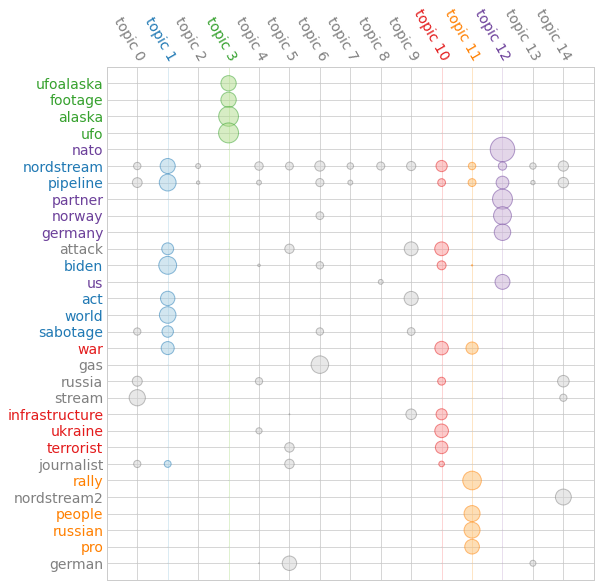

In [ ]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[1,3,10,11,12])

####Com 106

#####Train 

In [ ]:
documents = list(df106['text'].str.lower())

In [ ]:
corpus = textacy.Corpus("en_core_web_sm", documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)

tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [ ]:
model = textacy.tm.TopicModel("lda", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

In [ ]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: nation   sheep   stream   nord   we   🇩   investigation   german   pipeline   gas
topic 1: medium   president   partner   eu   mainstream   minded   norway   europeanunion   germany   nordstream
topic 2: biden   incident   siberian   clear   unprecedented   past   similar   gas   attack   civilian
topic 3: seymour   security   investigator   suicide   guard   asleep   pipeline   state   group   ukrainian
topic 4: u.s.   cia   year   natural   pipeline   world   people   nordstream   country   western
topic 5: possible   strong   brilliant   journ   hersh   pipeline   nordstream   leak   report   bombing
topic 6: time   methane   greenhouse   tonne   gas   co2   potent   metric   sabotage   nato
topic 7: nordstream2   us   nordstream1   new   lavrov   terror   usa   nordstream   ️   evidence
topic 8: russian   ukraine   europe   russia   war   destruction   nato   dependence   ship   official
topic 9: us   journalist   good   propaganda   empire   way   narrative   courage   me

#####Visualisation

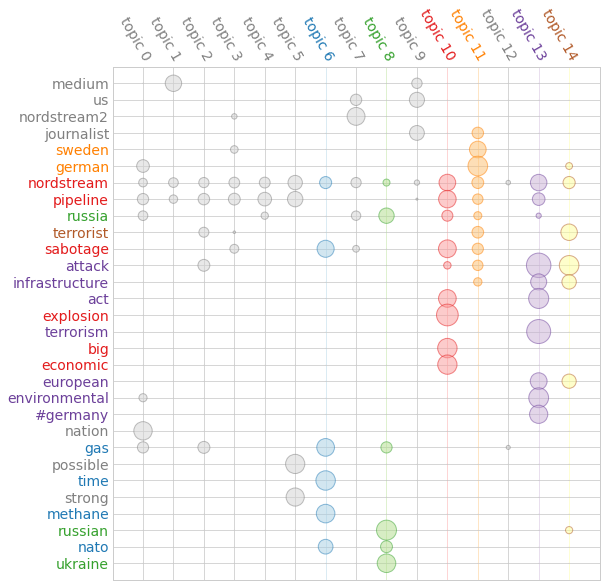

In [ ]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[6,8,10,11,13,14])

####Com 180


#####Train

In [ ]:
documents = list(df180['text'].str.lower())

In [ ]:
corpus = textacy.Corpus("multilingual", documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)

tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [ ]:
model = textacy.tm.TopicModel("lda", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

In [ ]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

#####Visaulisation

In [ ]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[4,5,9,13])

####Com246


#####Train

In [ ]:
documents = list(df246['text'].str.lower())

In [ ]:
corpus = textacy.Corpus("en_core_web_sm", documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)

tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [ ]:
model = textacy.tm.TopicModel("lda", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

#####Vizualisation

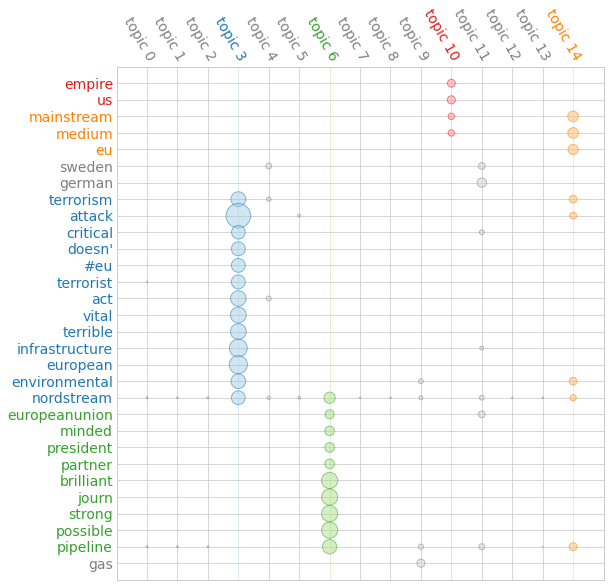

In [ ]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[3,6,10,14])

####Com 271

#####Train

In [ ]:
documents = list(df271['text'].str.lower())

In [ ]:
corpus = textacy.Corpus("en_core_web_sm", documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)

tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [ ]:
model = textacy.tm.TopicModel("lda", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

In [ ]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

#####Vizsualisation

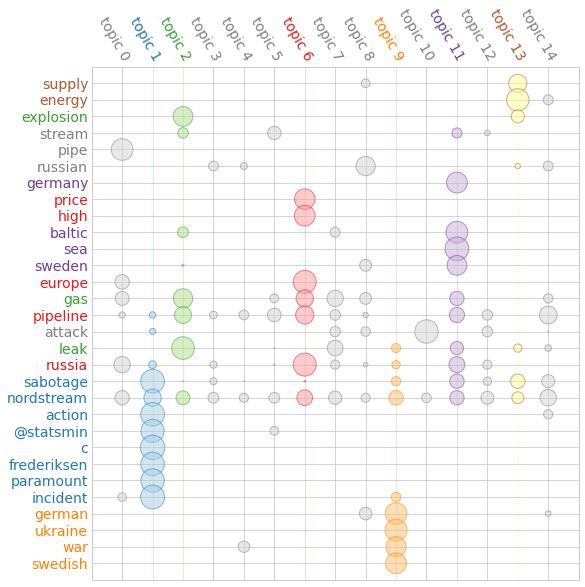

In [ ]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[1,2,6,9,11,13])

##Official figures' presence in the Dataset


In this last section we looked at which of the main politicians were in the dataset.

1. Create the politicians' df with the most prevalent figures in the official debate around Nord Stream

In [ ]:
dic = {"name" : ["Ursula von der Leyen","Joe Biden","Magdalena Anderson","Mateusz Marawiecki",
        "Dmitri Peskov","Nancy Faeser","Mette Frederiksen","Olaf Scholz","Radek Sikorski",
        "Sergei Ladrov","Sergei Ryabkov","Vladimr Putin","Jens Stoltenberg", "Jonas Gahr Støre"],
       "country" : ["EU","US","Sweden","Poland","Russia","Germany","Denmark","Germany","Poland (MEP)","Russia",
           "Russia","Russia","NATO", "Norway"],
       "twitter_handles" : ["vonderleyen","JoeBiden","INokkvi","MorawieckiM","","NancyFaeser","",
                   "OlafScholz","adeksikorski","","","","jensstoltenberg", "jonasgahrstore"]}
df_politicians = pd.DataFrame(dic)

2. Check if they are in one of the two datasets

In [ ]:
df_pol_tweets = df[df.user_username.isin(df_politicians["twitter_handles"])]
df_pol_tweets

,tweet_id,user_username,text,in_reply_to_user_id,conversation_id,created_at,possibly_sensitive,author_id,lang,user_verified,...,quote_count,user_tweet_count,user_list_count,user_followers_count,user_following_count,sourcetweet_type,sourcetweet_id,sourcetweet_text,sourcetweet_lang,sourcetweet_author_id
5391,x1574758636869636102,NancyFaeser,RT @BMI_Bund: Das Bundesinnenministerium nimmt...,NaN,x1574758636869636102,2022-09-27T13:51:31.000Z,False,x620221740,de,True,...,0,1867,679,144730,433,retweeted,x1574757428599693313,Das Bundesinnenministerium nimmt die Beschädig...,de,x588242800
27491,x1574856534064041996,vonderleyen,Spoke to @Statsmin Frederiksen on the sabotage...,NaN,x1574856534064041996,2022-09-27T20:20:31.000Z,False,x1146329871418843136,en,True,...,945,4105,6864,1438298,239,NaN,NaN,NaN,NaN,NaN
82441,x1575157073276452867,NancyFaeser,Die mutmaßlichen Sabotageakte an den #NordStre...,NaN,x1575157073276452867,2022-09-28T16:14:45.000Z,False,x620221740,de,True,...,41,1867,679,144729,433,NaN,NaN,NaN,NaN,NaN
207838,x1576868693304561668,vonderleyen,Good talk with @jonasgahrstore on the unaccept...,NaN,x1576868693304561668,2022-10-03T09:36:07.000Z,False,x1146329871418843136,en,True,...,49,4105,6864,1438316,239,NaN,NaN,NaN,NaN,NaN
209758,x1576915388742668289,jonasgahrstore,Pleased to talk to @vonderleyen. Agree that th...,NaN,x1576915388742668289,2022-10-03T12:41:41.000Z,False,x63129578,en,True,...,8,4347,1141,195933,13468,NaN,NaN,NaN,NaN,NaN


#####From this section we can conclude that  **only three of the main politicians** involved in the story have used the #NordStream. 